In [1]:
import os
import json
import bisect
import re
from pathlib import Path

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

import ipywidgets as widgets
from IPython.display import display, HTML

%matplotlib inline

pd.set_option('mode.chained_assignment', None)

In [2]:
basedir = Path("data")
dirs = [entry.name for entry in basedir.iterdir() if entry.is_dir()]
dd = widgets.Dropdown(
    options=sorted(dirs),
    description='Directory:'
)
display(dd)

Dropdown(description='Directory:', options=('BT', 'BT_bigLR_lowEpsDec', 'BT_bigRounds', 'BT_bigRounds_eqPriExp…

In [3]:
path = basedir / dd.value
metadata_files = []
data_files = []
for f in path.iterdir():
    file_name = f.name
    if file_name.endswith(".json"):
        metadata_files.append(file_name)
    elif file_name.endswith(".csv"):
        data_files.append(file_name)
    else:
        print("Cannot classify file: ", file_name)

In [4]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data, dtype=float)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m, m+h

In [5]:
runs = 1
metadata = {}
fingerprints = {}
tests = {}
for file_name in metadata_files:
    m = re.match(r"(.*)_(\d+)\(?(\d*)\)?(\..*)$", file_name)
    if m is None:
        print("Cannot parse", file_name)
    else:
        base, num, copy, ext = m.groups()
        num = int(num)
        runs = max(runs, num)
        with open(path / file_name) as f:
            file_dict = json.load(f)
            if copy == "":
                if base == "RunData":
                    metadata[num] = file_dict
                else:
                    fingerprints[num] = file_dict
            else:
                copy = int(copy)
                if tests.get(num) is None:
                    tests[num] = {}
                tests[num][copy] = file_dict

display(pd.DataFrame(metadata[1]["characters_info"]))

,Human2,Goblin1
type,Human,Goblin
network_id,Human2_1,Goblin1_1
team,team2,team1
speed,120,120
weight,1,1
max_life,30,30
damage,10,10
defense,0,0
controller_type,1,1
controller_name,Basic BT,Single QL


In [48]:
chars = set()
data_sets = {}
replay_times = {}
terminal_times = {}
num_tests = 1

def get_round(times_array):
    def f(time):
        return bisect.bisect_left(times_array, time)
    return f

def get_round_time(times_array):
    def f(time):
        idx = bisect.bisect_left(times_array, time)
        if idx == 0:
            return time
        begin_time = times_array[idx - 1]
        return time - begin_time
    return f

for file_name in data_files:
    m = re.match(r"(.*)_(.*?)_(\d+)\(?(\d*)\)?(\..*)$", file_name)
    base, char, run, copy, ext = m.groups()
    run = int(run)
    
    if copy != "":
        num_tests = max(num_tests, int(copy))
        continue
    
    chars.add(char)
    print("-----", run, " ", char, "-----")
    
    data = pd.read_csv(path / file_name)
    
    if data_sets.get(run) is None:
        data_sets[run] = {}
        replay_times[run] = {}

    data_sets[run][char] = data
    print("data size: ", data.shape)

    replays = sorted(data[data["replay"] == True]["time"].value_counts().keys().tolist())
    replay_times[run][char] = replays
    print("replays: ", len(replays))
    
    terminal_data = data[data["terminal"] == True]
    terminal_count = terminal_data[terminal_data["replay"] == False]["time"].value_counts()
    print(set(terminal_count))
    terminals = sorted(terminal_count.keys().tolist())
    terminal_times[run] = terminals
    print("terminals: ", len(terminals))
    
    discount = metadata[run]["characters_info"][char]["discount"]
    data["label"] = data["reward"] + discount * data["next_val"] * (~ data["terminal"])
    data["loss"] = (data["label"] - data["q_val"])**2
    data["round"] = data["time"].map(get_round(replays))
    data["round_time"] = data["time"].map(get_round_time(replays))
    
chars = sorted(list(chars))
print("List of characters:", chars)
print("Number of tests:", num_tests)
num_chars = len(chars)

----- 10   Goblin1 -----
data size:  (293543, 28)
replays:  8775
{1}
terminals:  120
----- 6   Goblin1 -----
data size:  (300209, 28)
replays:  8977
{1}
terminals:  120
----- 8   Goblin1 -----
data size:  (308689, 28)
replays:  9233
{1}
terminals:  120
----- 1   Goblin1 -----
data size:  (398977, 28)
replays:  11969
{1}
terminals:  120
----- 4   Goblin1 -----
data size:  (400825, 28)
replays:  12025
{1}
terminals:  120
----- 9   Goblin1 -----
data size:  (411385, 28)
replays:  12345
{1}
terminals:  120
----- 2   Goblin1 -----
data size:  (209854, 28)
replays:  6238
{1}
terminals:  120
----- 7   Goblin1 -----
data size:  (366406, 28)
replays:  10982
{1}
terminals:  120
----- 3   Goblin1 -----
data size:  (402508, 28)
replays:  12076
{1}
terminals:  120
----- 5   Goblin1 -----
data size:  (332878, 28)
replays:  9966
{1}
terminals:  120
List of characters: ['Goblin1']
Number of tests: 3


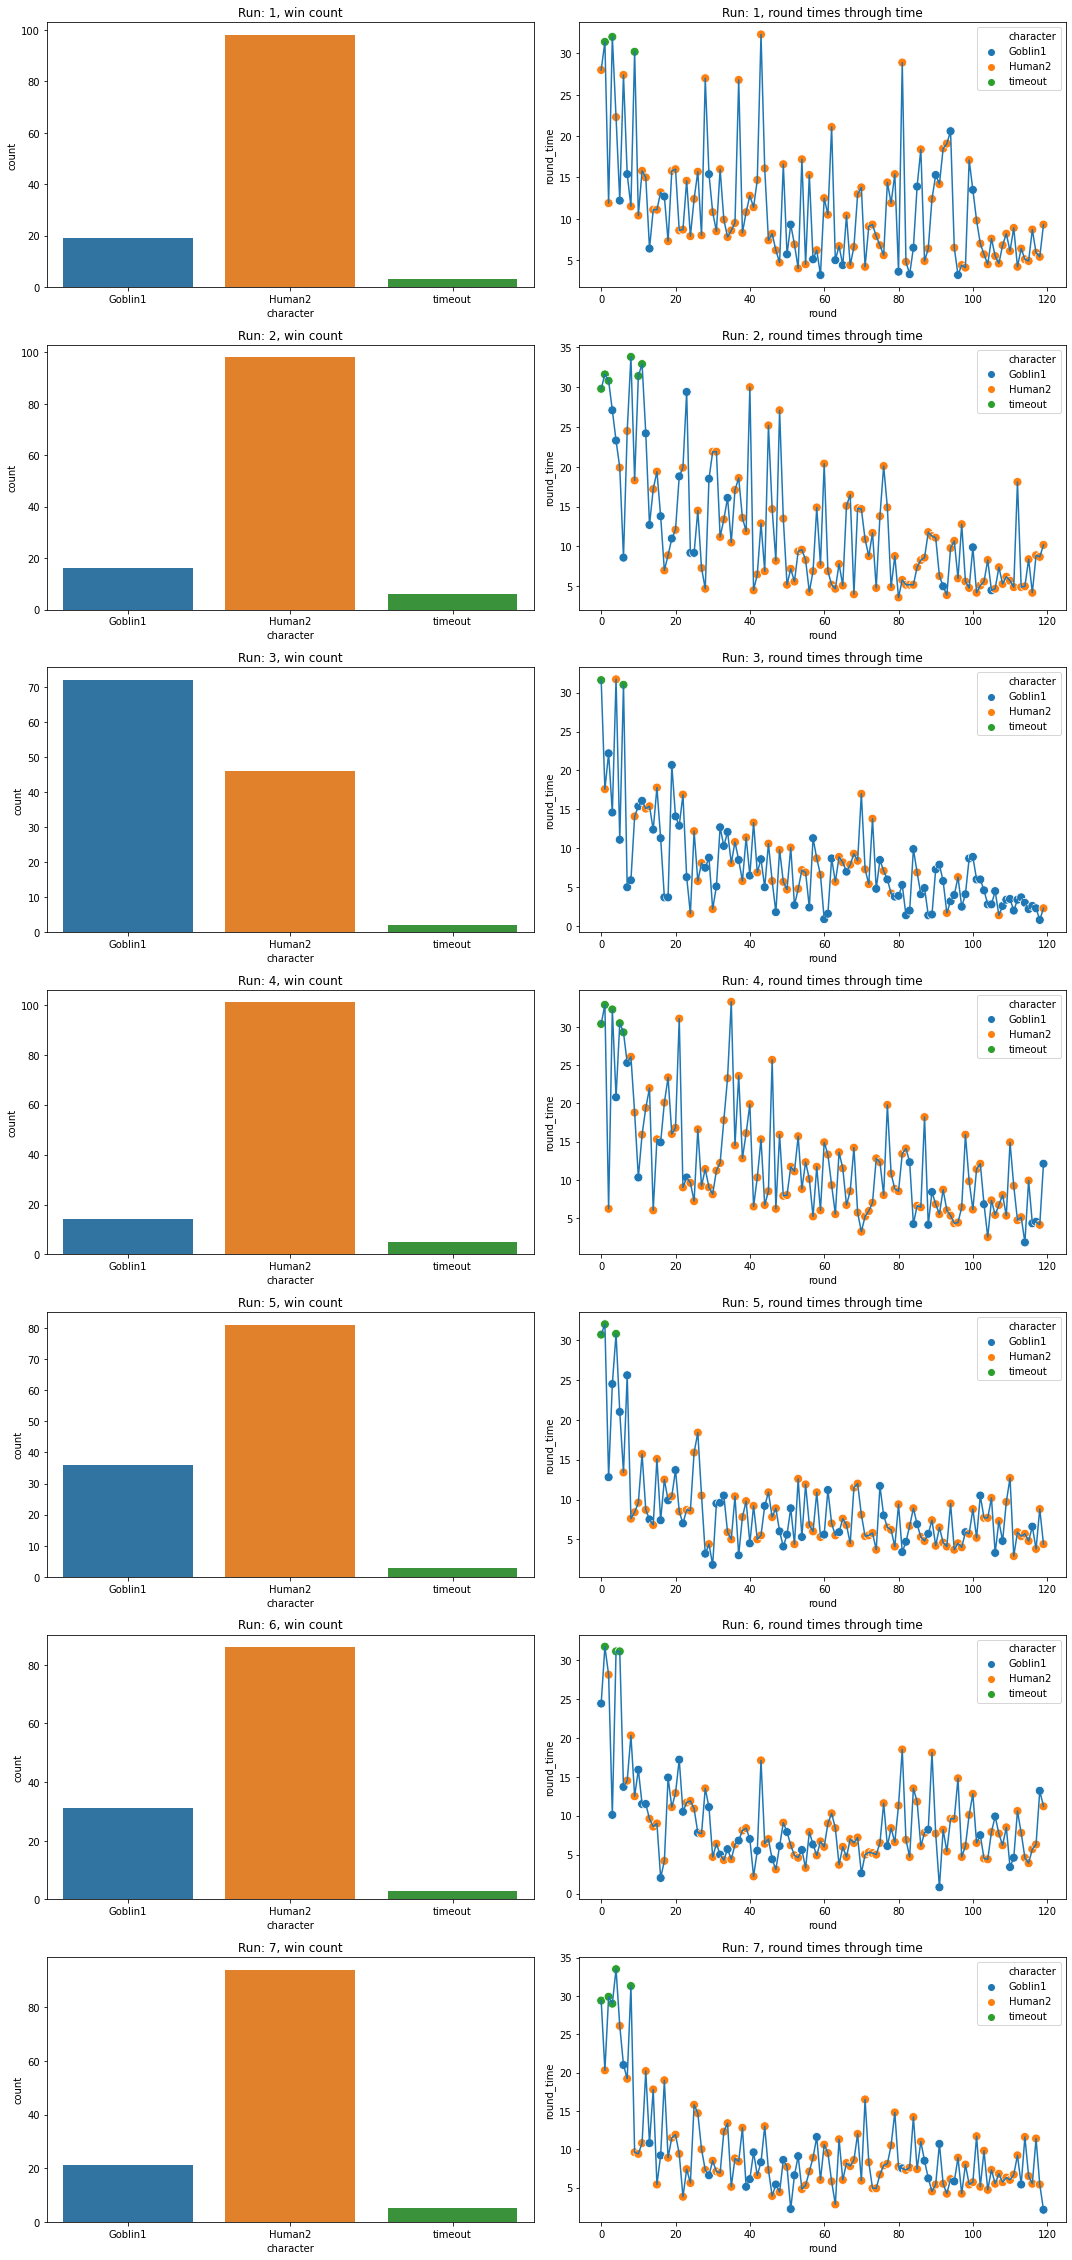

In [35]:
# Gráficos mostrando histograma de vitórias

order = sorted(["timeout"] + list(metadata[1]["characters_info"].keys()))
fig, ax = plt.subplots(runs, 2, figsize=(15, 4.5 * runs))
for run in range(runs):
    ax[run][0].set_title(f"Run: {run + 1}, win count")
    winners = metadata[run + 1]["winners"]
    winners_table = pd.DataFrame({"time": terminal_times[run + 1], "character": winners}).reset_index().rename(columns={"index": "round"})
    winners_table["round_time"] = winners_table["time"] - winners_table["time"].shift(1)
    winners_table["round_time"][0] = winners_table["time"][0]
    winners_table = winners_table.iloc[0:len(terminal_times[run + 1])]
    sns.countplot(x="character", data=winners_table, order=order, ax=ax[run][0])
    ax[run][1].set_title(f"Run: {run + 1}, round times through time")
    sns.lineplot(x="round", y="round_time", data=winners_table, ax=ax[run][1])
    sns.scatterplot(x="round", y="round_time", hue="character", hue_order=order, s=80, data=winners_table, ax=ax[run][1])
plt.tight_layout()
plt.show()

In [39]:
# Tabela com as estatísticas dos gráficos da célula anterior
win_rates = {c: [] for c in chars}
mean_round_times = {c: [] for c in chars}
std_round_times = {c: [] for c in chars}
num_exploit_rounds = []
chars_info = metadata[1]["characters_info"]
num_rounds = metadata[1]["rounds"]
min_time = max([info["exploration_rate_decay_time"] for info in chars_info.values()])

for run in range(runs):
    run_metadata = metadata[run + 1]
    run_data = data_sets[run + 1]
    winners = run_metadata["winners"]
    for c in chars:
        data = run_data[c]
        terminal_states = data[(data["replay"] == False) & (data["terminal"] == True)]
        exploit_rounds = terminal_states[terminal_states["time"] > min_time]
        num_exploit_rounds.append(len(exploit_rounds))
        if len(exploit_rounds) == 0:
            mean_round_times[c].append(-1)
            std_round_times[c].append(-1)
            win_rates[c].append(-1)
            continue
        round_times = (exploit_rounds["time"] - exploit_rounds["time"].shift(1)).shift(-1)
        mean_round_times[c].append(round_times.mean())
        std_round_times[c].append(round_times.std())
        char_winners = pd.DataFrame({"time": terminal_states["time"].to_list(), "character": winners})
        char_winners = char_winners[char_winners["time"] > min_time]
        counts = char_winners["character"].value_counts()
        win_rates[c].append(counts.get(c, 0.0) / counts.sum())

stats_table = {"num_exploit_rounds": num_exploit_rounds}
confidence_intervals = {"win_rate": {}}
for c in chars:
    valid_win_rates = [r for r in win_rates[c] if r != -1.0]
    win_rate_interval = "({:.4f}, {:.4f}, {:.4f})".format(*mean_confidence_interval(valid_win_rates))
    confidence_intervals["win_rate"][c] = win_rate_interval
    stats_table[c + "_win_rate"] = win_rates[c]
    stats_table[c + "_mean_round_times"] = mean_round_times[c]
    stats_table[c + "_std_round_times"] = std_round_times[c]
display(pd.DataFrame(stats_table))
display(pd.DataFrame(confidence_intervals))

,num_exploit_rounds,Goblin1_win_rate,Goblin1_mean_round_times,Goblin1_std_round_times
0,61,0.180328,9.286667,5.441475
1,75,0.040000,8.717568,4.614609
2,36,0.861111,3.974286,2.159976
3,74,0.121622,8.754795,3.979567
4,36,0.194444,6.257143,2.324332
5,36,0.194444,7.891429,3.514790
6,49,0.142857,7.304167,2.635111


,win_rate
Goblin1,"(-0.0073, 0.2478, 0.5029)"


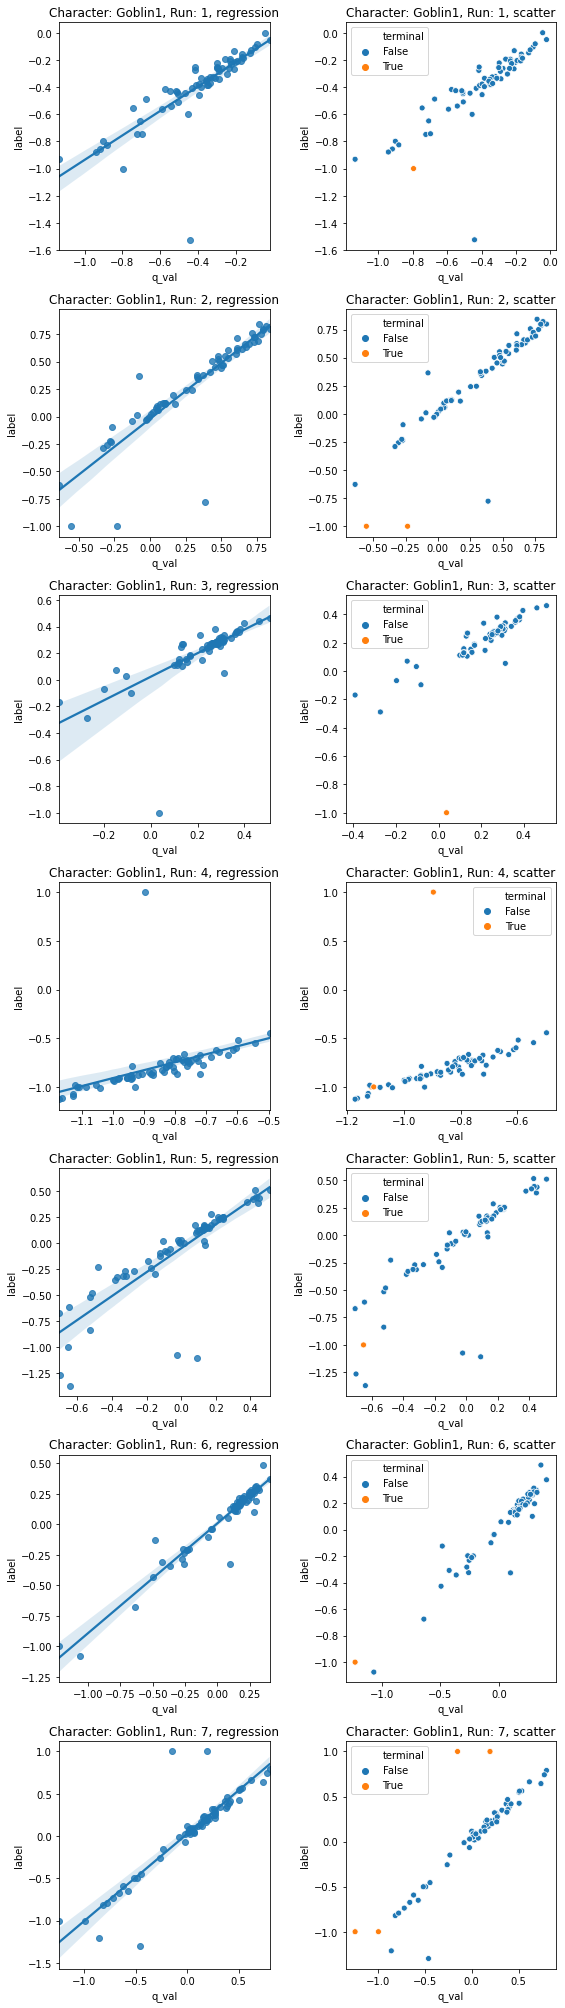

In [40]:
# Gráficos mostrando relação q-val x label no último replay

fig, ax = plt.subplots(runs, 2 * num_chars, figsize=(8 * num_chars, 4 * runs))
for i in range(1, runs + 1):
    for j, char in enumerate(chars):
        ax[i - 1][2 * j + 0].set_title(f"Character: {char}, Run: {i}, regression")
        ax[i - 1][2 * j + 1].set_title(f"Character: {char}, Run: {i}, scatter")
        data = data_sets[i][char]
        if len(replay_times[i][char]) != 0:
            last_replay_time = replay_times[i][char][-1]
            this_time_data = data[data["time"] == last_replay_time]
            sns.regplot(x="q_val", y="label", data=this_time_data, ax=ax[i - 1][2 * j + 0])
            sns.scatterplot(x="q_val", y="label", hue="terminal", data=this_time_data, ax=ax[i - 1][2 * j + 1])
plt.tight_layout()
plt.show()

In [11]:
# Gráficos mostrando evolução da distância da IA ao inimigo conforme o tempo, com hue = número do round

fig, ax = plt.subplots(runs, num_chars, figsize=(8 * num_chars, 4 * runs), squeeze=False, sharex=True)
for i in range(1, runs + 1):
    for j, char in enumerate(chars):
        ax[i - 1][j].set_title(f"Character: {char}, Run: {i}")
        data = data_sets[i][char]
        data = data[(data["replay"] == False) & (data["round"] != 0)]
        sns.lineplot(x="round_time", y="enemy_dist", hue="round", data=data, ax=ax[i - 1][j])
plt.tight_layout()
plt.show()

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7faa93e50ee0> (for post_execute):


KeyboardInterrupt: 

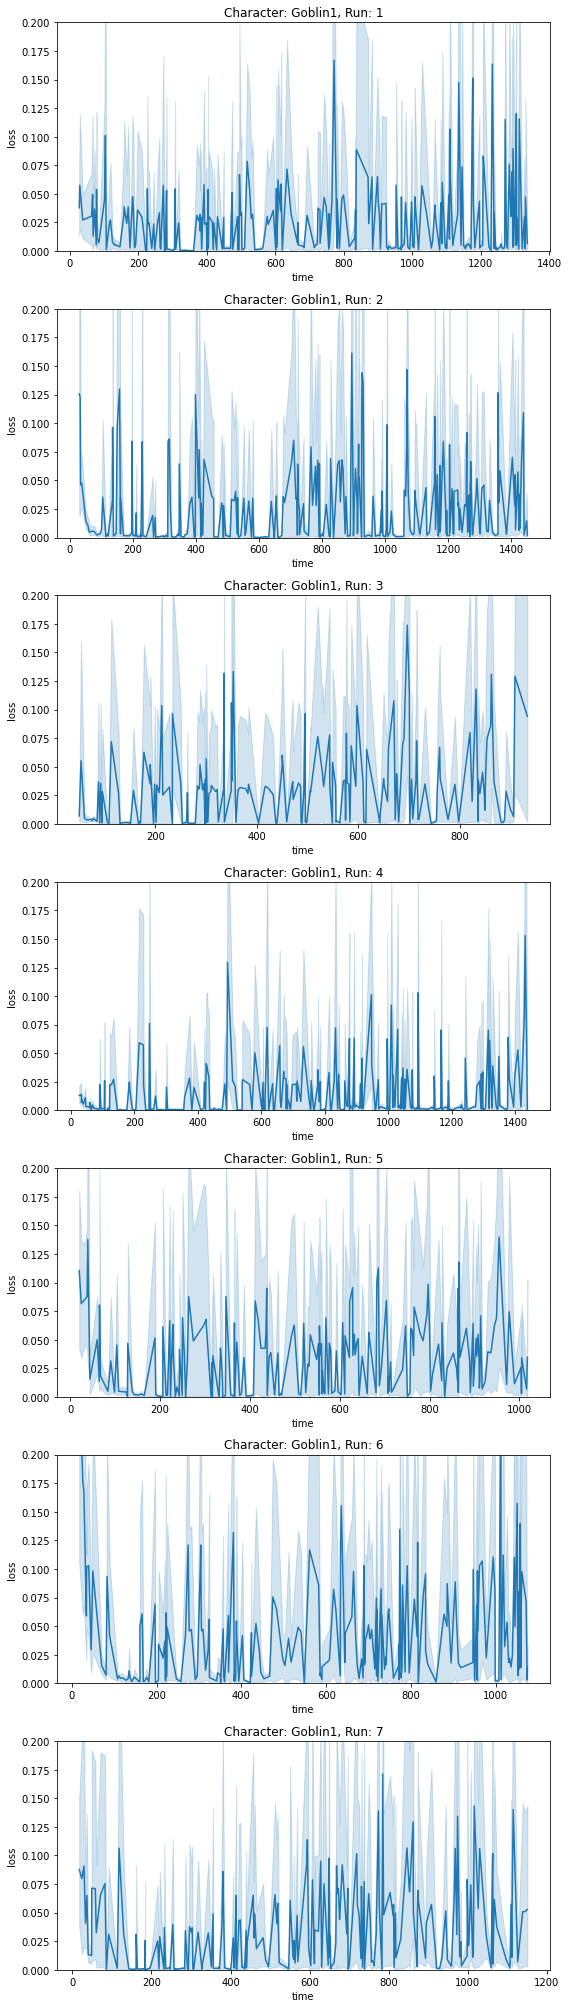

In [41]:
# Comparação da função de perda

fig, ax = plt.subplots(runs, num_chars, figsize=(8 * num_chars, 4 * runs), squeeze=False)
for i in range(1, runs + 1):
    for j, char in enumerate(chars):
        ax[i - 1][j].set_title(f"Character: {char}, Run: {i}")
        data = data_sets[i][char]
        data = data[data["replay"] == True]
        selected_times = []
        for k, time in enumerate(data["time"].value_counts().keys()):
            if k % 50 == 0:
                selected_times.append(time)
        sns.lineplot(x="time", y="loss", data=data[data["time"].isin(selected_times)], ax=ax[i - 1][j])
        ax[i - 1][j].set_ylim(0.0, 0.2)
plt.tight_layout()
plt.show()

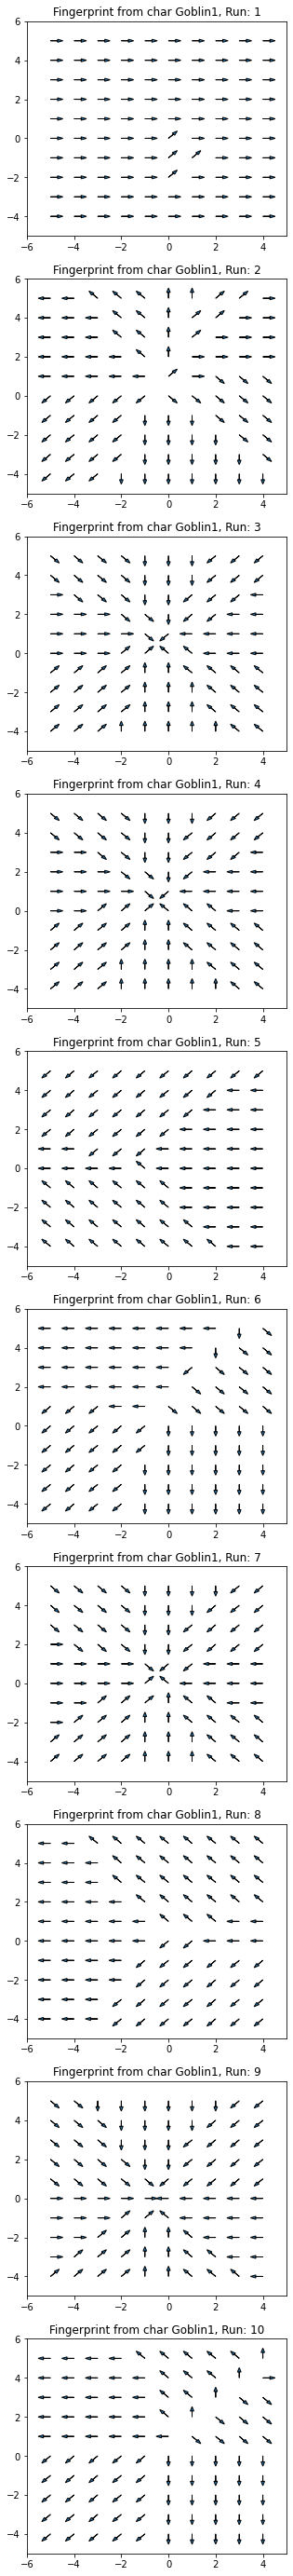

In [51]:
# Mostra a visualização das fingerprints

a = 0.3
arrows = {
    "walk_right": (a, 0.0),
    "walk_up_right": (a * np.sqrt(2) / 2, a * np.sqrt(2) / 2),
    "walk_up": (0.0, a),
    "walk_up_left": (- a * np.sqrt(2) / 2, a * np.sqrt(2) / 2),
    "walk_left": (- a, 0.0),
    "walk_down_left": (- a * np.sqrt(2) / 2, - a * np.sqrt(2) / 2),
    "walk_down": (0.0, - a),
    "walk_down_right": (a * np.sqrt(2) / 2, - a * np.sqrt(2) / 2),
    "idle": (0.0, 0.0),
    "attack": (0.0, 0.0)
}

fig, ax = plt.subplots(runs, 1, figsize=(5, 5 * runs))
for run in range(0, runs):
    fps = fingerprints[run + 1]
    for name, fp in fps.items():
        ax[run].set_title(f"Fingerprint from char {name}, Run: {run + 1}")
        for i, col in enumerate(fp):
            for j, el in enumerate(col):
                x = i - 5
                y = 5 - j
                if el == "idle":
                    ax[run].add_artist(plt.Circle((x, y), a, color='b'))
                elif el == "attack":
                    ax[run].add_artist(plt.Rectangle((x, y), a, a, color='r'))
                else:
                    dx, dy = arrows[el]
                    ax[run].arrow(x, y, dx, dy, head_width=0.15)
        ax[run].set_xlim(-6.0, 5.0)
        ax[run].set_ylim(-5.0, 6.0)
plt.show()

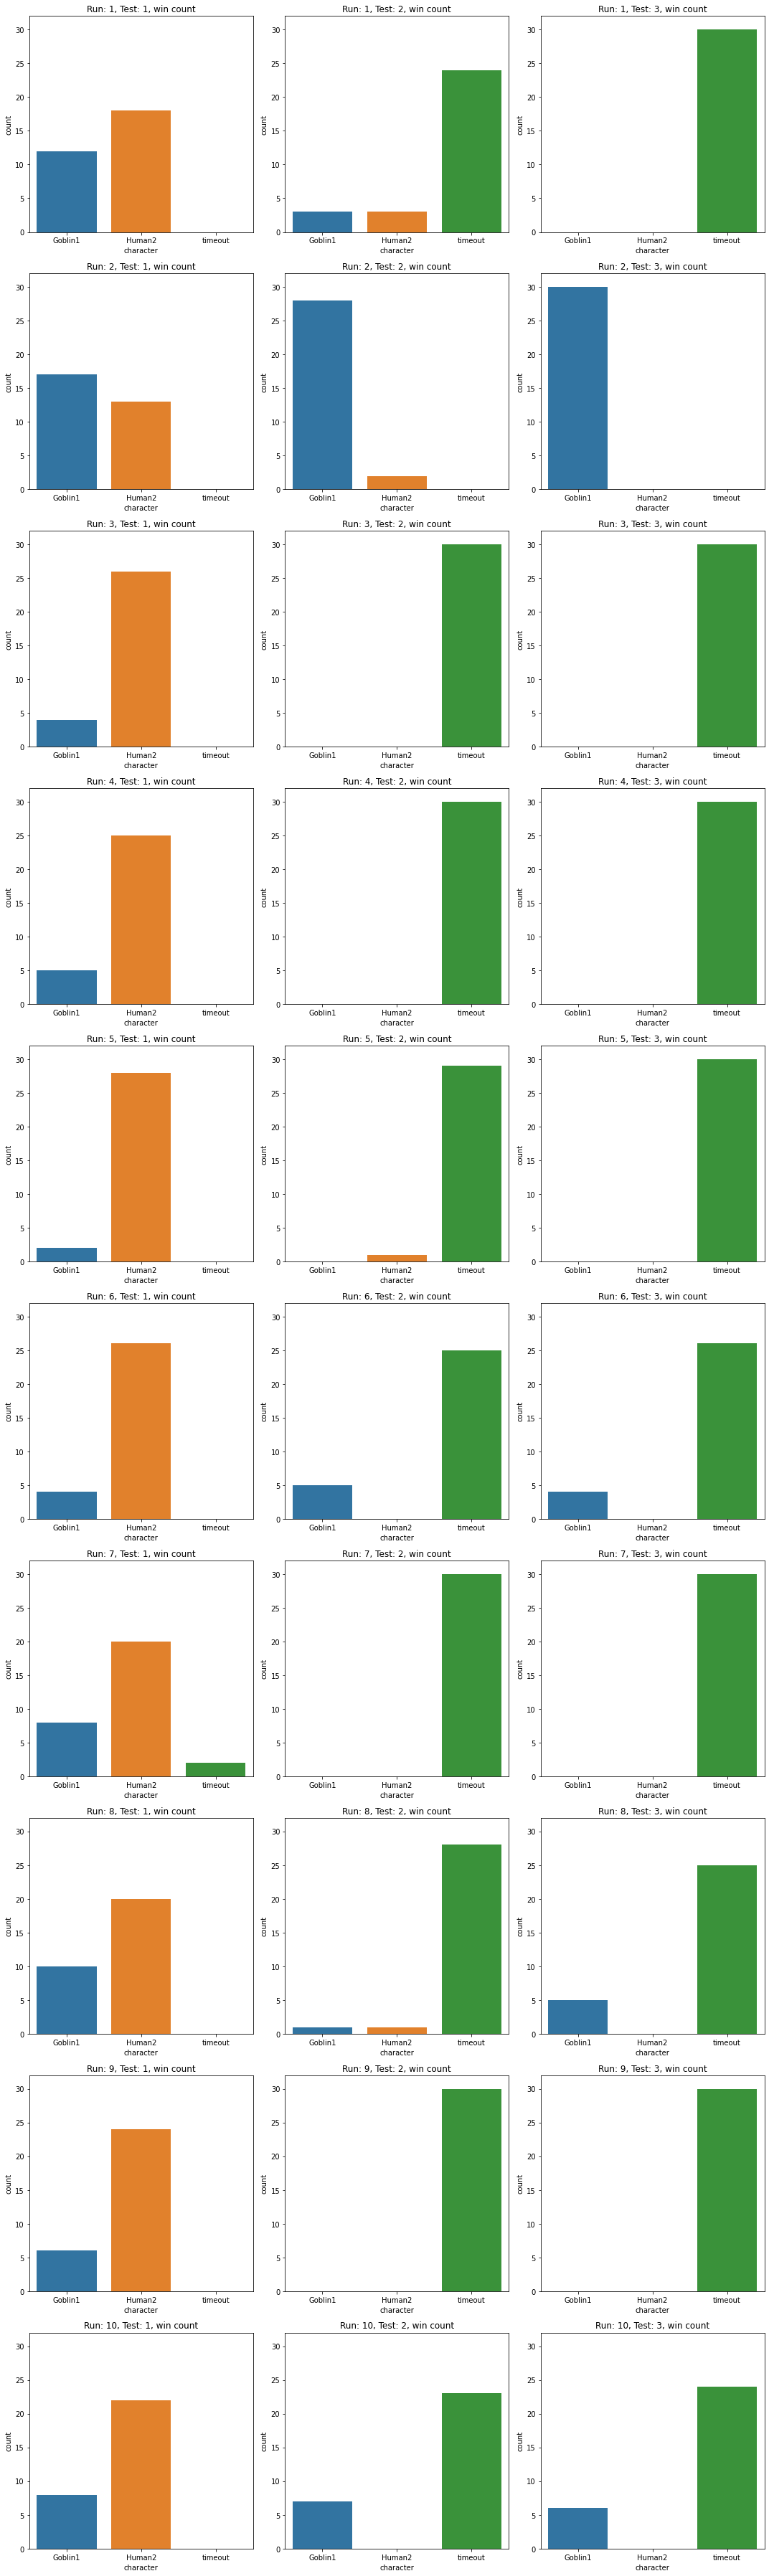

In [52]:
intervals = []

fig, ax = plt.subplots(runs, num_tests, figsize=(5 * num_tests, 5 * runs))
for test in range(num_tests):
    order = sorted(["timeout"] + list(tests[1][test + 1]["characters_info"].keys()))
    ai_name = list(tests[1][test + 1]["params"].keys())[0]
    win_rates = []
    for run in range(runs):
        ax[run][test].set_title(f"Run: {run + 1}, Test: {test + 1}, win count")
        test_metadata = tests[run + 1][test + 1]
        winners = test_metadata["winners"]
        rounds = len(winners)
        winners_table = pd.DataFrame({"character": winners}).reset_index().rename(columns={"index": "round"})
        sns.countplot(x="character", data=winners_table, order=order, ax=ax[run][test])
        win_rates.append(sum([winner == ai_name for winner in winners]) / rounds)
        ax[run][test].set_ylim(0, rounds + 2)
    intervals.append({
        "test": test + 1,
        "ai_name": ai_name,
        "win_rate": "({:.4f}, {:.4f}, {:.4f})".format(*mean_confidence_interval(win_rates))
    })

plt.tight_layout()
plt.show()

In [53]:
display(pd.DataFrame(intervals))

,test,ai_name,win_rate
0,1,Goblin1,"(0.1466, 0.2533, 0.3601)"
1,2,Goblin1,"(-0.0597, 0.1467, 0.3531)"
2,3,Goblin1,"(-0.0712, 0.1500, 0.3712)"


In [77]:
# Mostrar com várias bolinhas no 2D quando foi que aconteceram eventos de perda de vida